### Домашнее задание "Модели ARIMA"

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
series = pd.read_csv('monthly-sales-of-company-x-jan-6.csv')['Count']

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


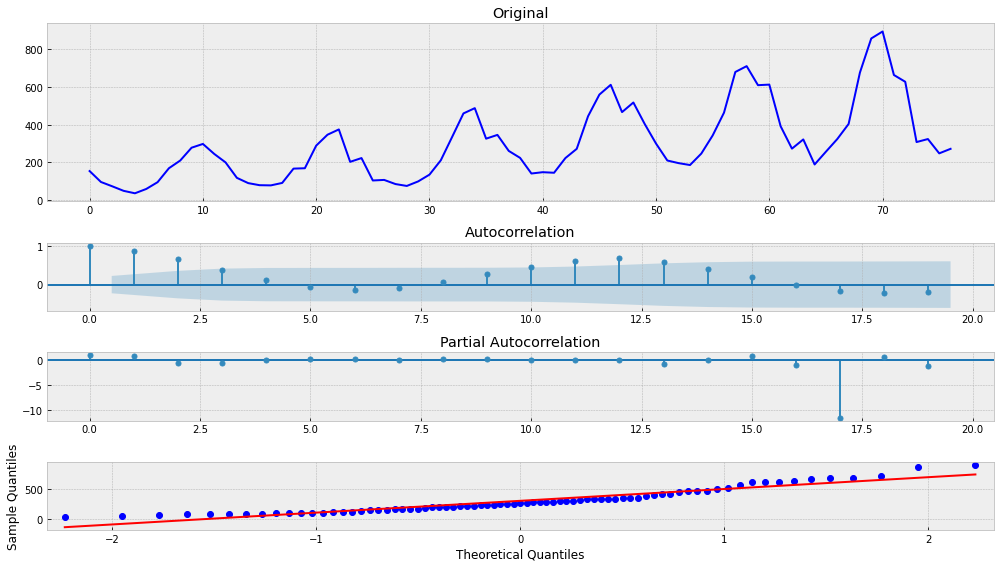

In [5]:
tsplot(series)

In [6]:
series = boxcox(series, 0)

aic: -33.21456 | order: (3, 1, 2)
Results of Dickey-Fuller Test:
Test Statistic                -9.171944e+00
p-value                        2.375336e-15
#Lags Used                     0.000000e+00
Number of Observations Used    7.500000e+01
Critical Value (1%)           -3.520713e+00
Critical Value (5%)           -2.900925e+00
Critical Value (10%)          -2.587781e+00
dtype: float64


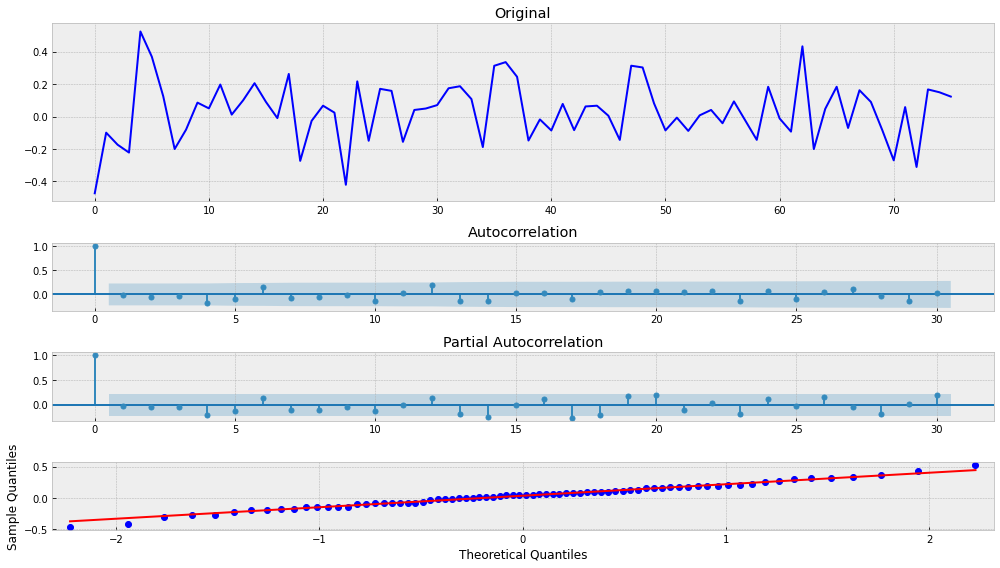

In [7]:
# функция подбирает оптимальные значения p,d,q для модели ARIMA, по критерию Акаике

# по дефолту определяются параметры: акаике, параметры p,d,q, модель ARIAM
best_aic = np.inf 
best_order = None
best_mdl = None

# цикл перебирает параметры p,d,q, которые руками задаются в range каждого цикла
for i in range(7):
    for d in range(3):
        for j in range(7):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                # если критерий акаике наименьший, по нему фиксируются параметры p,d,q и строится модель
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

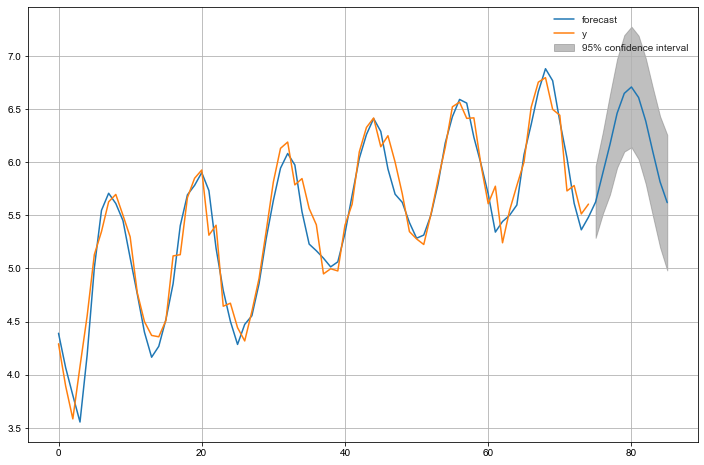

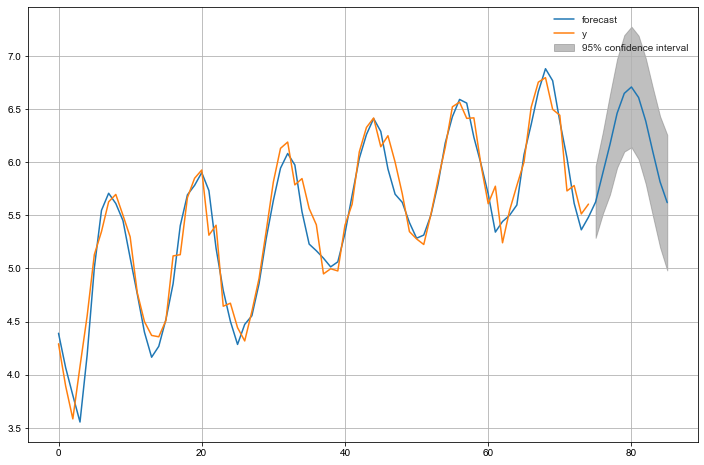

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.style.use('seaborn-darkgrid')
best_mdl.plot_predict(2, len(series)+10, ax=ax) 

параметры которые описывают ряд (3, 1, 2)  
теперь сделаем предсказание на тесте и оценим качество

In [9]:
len(series)

77

In [22]:
# разделим на тренировочные и тестовые данные
train_series = series[:71]
test_series = series[71:]

In [23]:
# строим модель на тренировочных данных, и передаем подобрынные ранее параметры 
model = smt.ARIMA(train_series, order=(3,1,2)).fit(method='mle', trend='nc')

In [24]:
len(test_series)

6

In [25]:
# предсказываем 6 значений
pred = model.forecast(steps=6)[0]

In [26]:
# посчитаем метрики качества предсказания
print(f'RMSE: {(np.sqrt(mean_squared_error(test_series, pred))):.0f}')
print(f'MAPE: {(np.mean(np.abs((test_series - pred) / test_series)) * 100):.0f}')

RMSE: 0
MAPE: 4


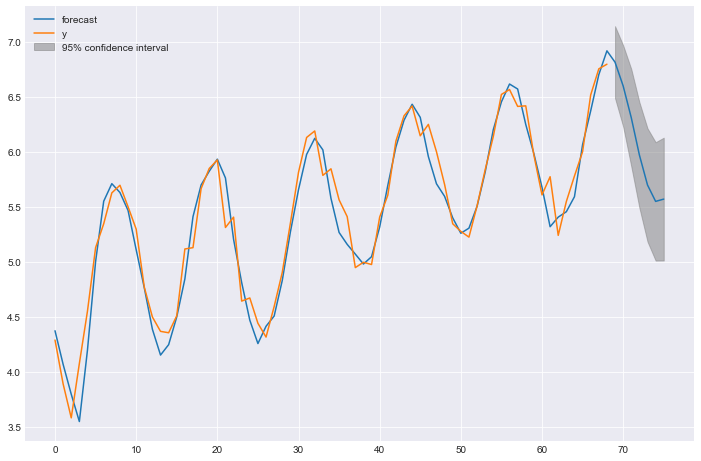

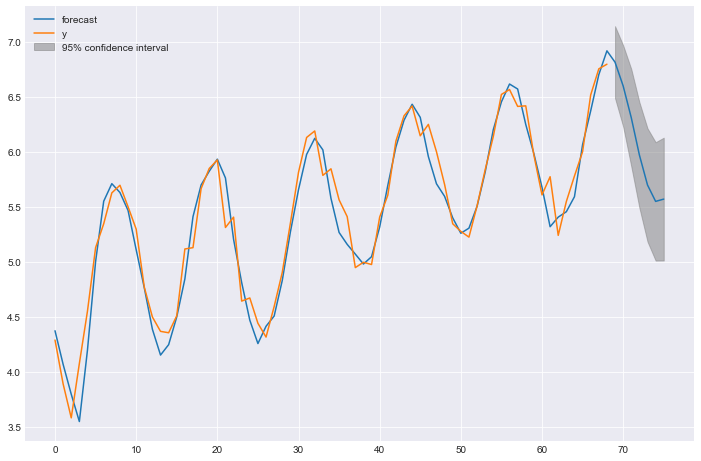

In [36]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.style.use('seaborn-darkgrid')
model.plot_predict(2, len(train_series)+6, ax=ax) 

Модель классчической ML

In [28]:
series = pd.read_csv('monthly-sales-of-company-x-jan-6.csv')

In [29]:
# функция раскладывает временной ряд на признаки, формирует новый датасет. и делит на тренеровочные и тестовые данные
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [30]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=5, lag_end=20, test_size=0.3)

In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
# обучим модель линейной регрессии
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

In [37]:
# посчитаем метрики качества предсказания
print(f'RMSE: {(np.sqrt(mean_squared_error(y_test, prediction))):.0f}')

RMSE: 124


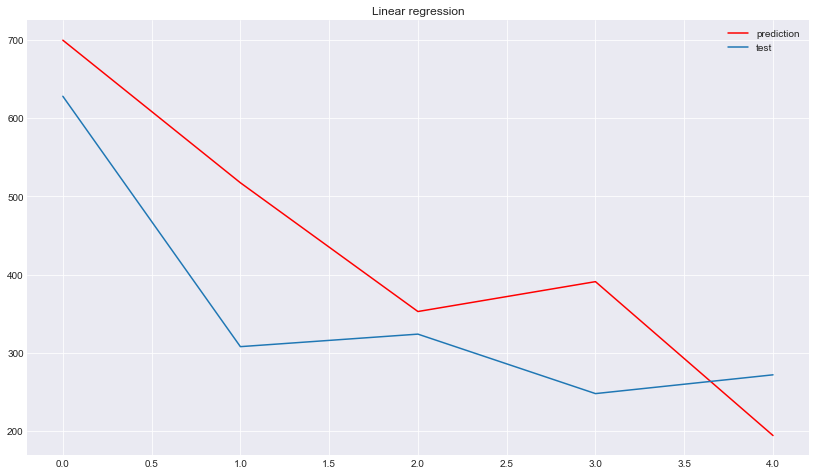

In [38]:
plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="test")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);